In [42]:
import umap
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.datasets import fetch_openml
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.metrics import r2_score 
from scipy.stats import spearmanr
import statsmodels.formula.api as smf
from sklearn.cross_decomposition import PLSRegression

# Preparing MNIST dataset

In [17]:
mnist = fetch_openml("mnist_784", version = 1)
labels = mnist.target.astype(int)
print(mnist.data.shape)

(70000, 784)


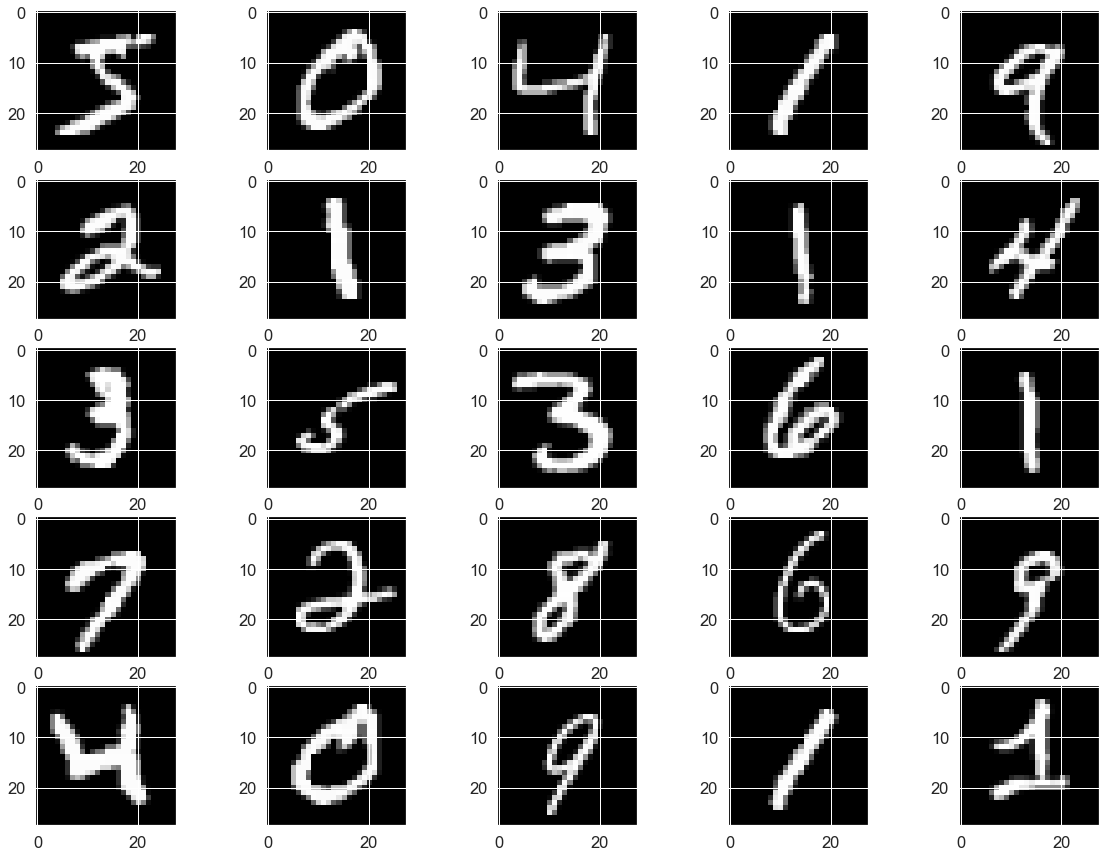

In [18]:
plt.figure(figsize = (20, 15))

for i in range (25):
    plt.subplot(5, 5, i + 1)
    plt.imshow(mnist.data.loc[i].values.reshape(28, 28), cmap = plt.get_cmap("gray"))
    
plt.show()

In [19]:
N_points = 10000
X = np.log10(mnist.data + 1)

In [20]:
np.random.seed(123)
random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
X = X.loc[random_indices,:]
labels = labels[random_indices]

# Application of PCA, tSNE and UMAP

Observed variance explained:  [0.11043074 0.07698788 0.06564009 0.05835455 0.04983201 0.04556471
 0.03336833 0.02898735 0.02736869 0.02373547]
Finished 1 permutations
Finished 2 permutations
Finished 3 permutations
Finished 4 permutations
Finished 5 permutations
Finished 6 permutations
Finished 7 permutations
Finished 8 permutations
Finished 9 permutations
Finished 10 permutations
Permuted variance explained:  [0.0021104952237763585, 0.0020828173531311045, 0.0020737835173461686, 0.0020681815370765296, 0.0020594072690765693, 0.002054177395672736, 0.0020443912633945314, 0.002040223352944921, 0.002036894944090822, 0.002031249372729857]
Number of significant Principal Components: 62
Together they explain 86% of variation in the data


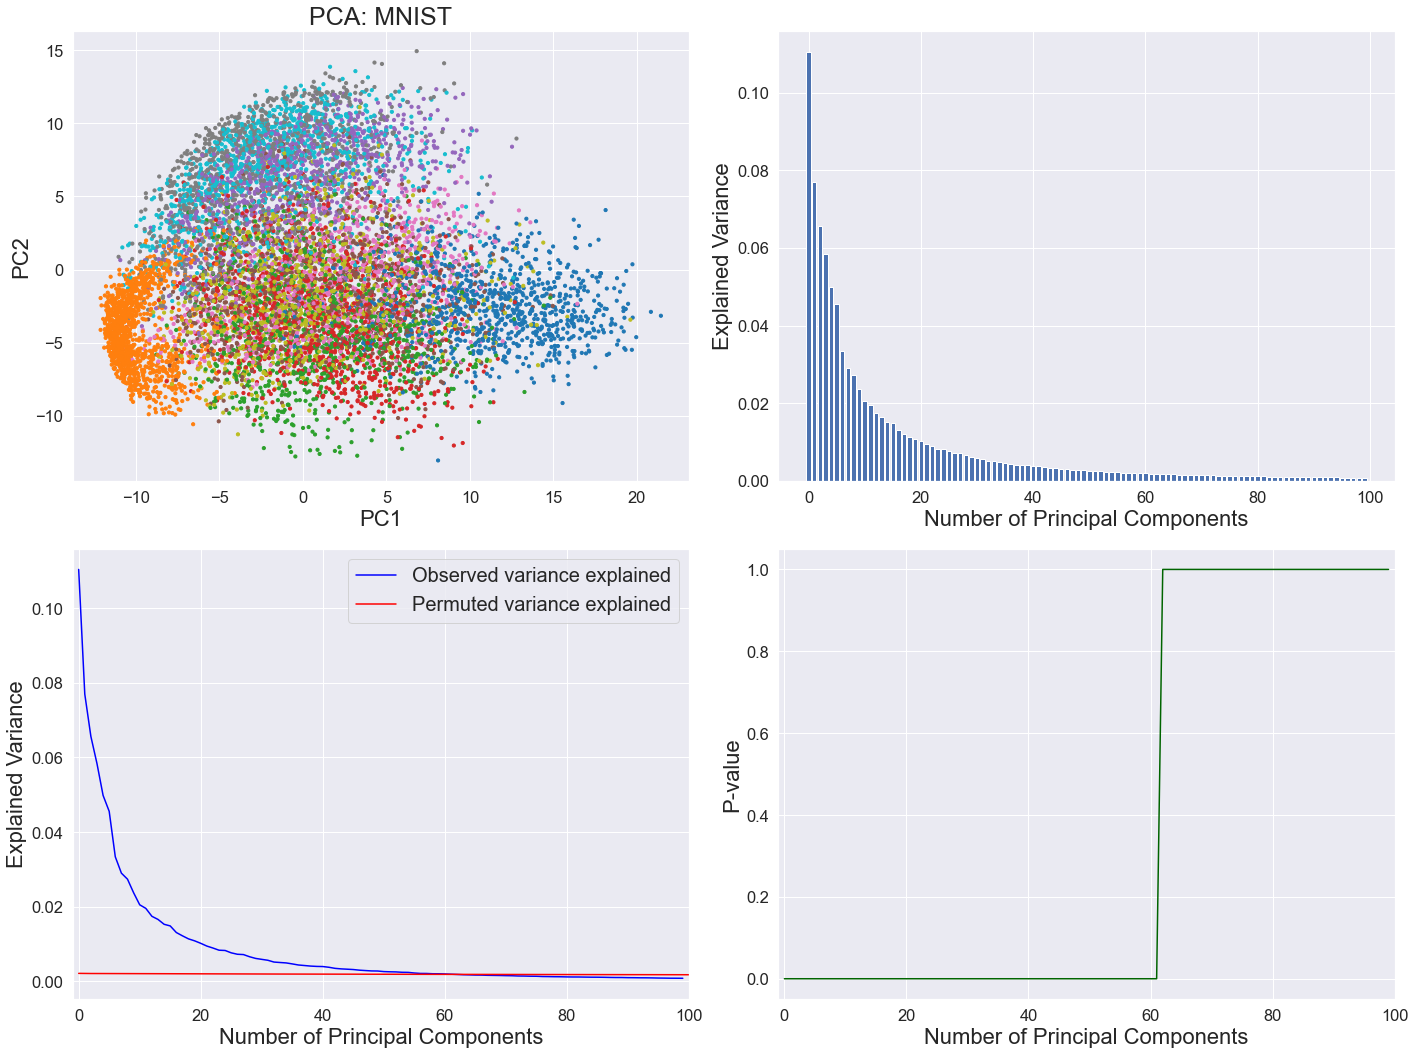

In [21]:
N_pca_comps = 100
sns.set(font_scale = 1.5) 
figure = plt.figure(figsize = (20, 15))

plt.subplot(221)
X_reduced = PCA(n_components = 2).fit_transform(X)
plt.scatter(X_reduced[:,0], X_reduced[:, 1], c=labels, cmap="tab10", s = 10)
plt.title("PCA: MNIST", fontsize = 25)
plt.xlabel("PC1", fontsize = 22) 
plt.ylabel("PC2", fontsize = 22)

plt.subplot(222)
pca = PCA(n_components = N_pca_comps).fit(X)
print("Observed variance explained: ", 
      pca.explained_variance_ratio_[0:10], 
      end = "\n")
plt.bar(range(len(pca.explained_variance_ratio_)), 
        pca.explained_variance_ratio_)
plt.xlabel("Number of Principal Components", fontsize = 22)
plt.ylabel("Explained Variance", fontsize = 22)

N_perm = 10
X_flat = X.squeeze().values.flatten()
expl_var_perm_df = pd.DataFrame(index = list(range(N_perm)), 
                                columns = list (range (X.shape[1])))
for i in range(N_perm):
    np.random.shuffle(X_flat)
    X_perm = X_flat.reshape(X.shape[0], X.shape[1])
    pca_perm = PCA().fit(X_perm)
    expl_var_perm_df.loc[i] = pca_perm.explained_variance_ratio_
    print("Finished {} permutations".format(i + 1), end = "\n")
    X_perm = list(expl_var_perm_df.mean (axis = 0) +
                  2 * expl_var_perm_df.std(axis = 0))
    
print('Permuted variance explained: ', X_perm[0:10], end = "\n")

plt.subplot(223)
plt.plot(pca.explained_variance_ratio_, c = "blue")
plt.plot(X_perm, c = "red") 
plt.xlim([-1, N_pca_comps])
plt.xlabel("Number of Principal Components", fontsize = 22)
plt.ylabel("Explained Variance", fontsize = 22)
plt.gca().legend(("Observed variance explained",
                  "Permuted variance explained"), fontsize = 20)

plt.subplot (224)
pval = list()
for j in range(N_pca_comps): 
    pval.append(np.sum(expl_var_perm_df.iloc[:, j] +
                2 * expl_var_perm_df.std(axis = 0) >=
                pca.explained_variance_ratio_[j]) / N_perm)
plt.plot(pval, c = "darkgreen")
plt.xlabel("Number of Principal Components", fontsize = 22)
plt.ylabel("P-value", fontsize = 22) 
plt.xlim ([-1, N_pca_comps])
N_opt_pcs = np.where(np.array(pval) >= 0.05)[0][0]
print("Number of significant Principal Components: {}".format(N_opt_pcs))
print("Together they explain {}% of variation in the data".format(int(round(sum(pca.explained_variance_ratio_[0: np.where(np.array(pval) >= 0.05)[0][0]]) * 100, 0))))
figure.tight_layout()
plt.show()

/Users/RomanGorelsky/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


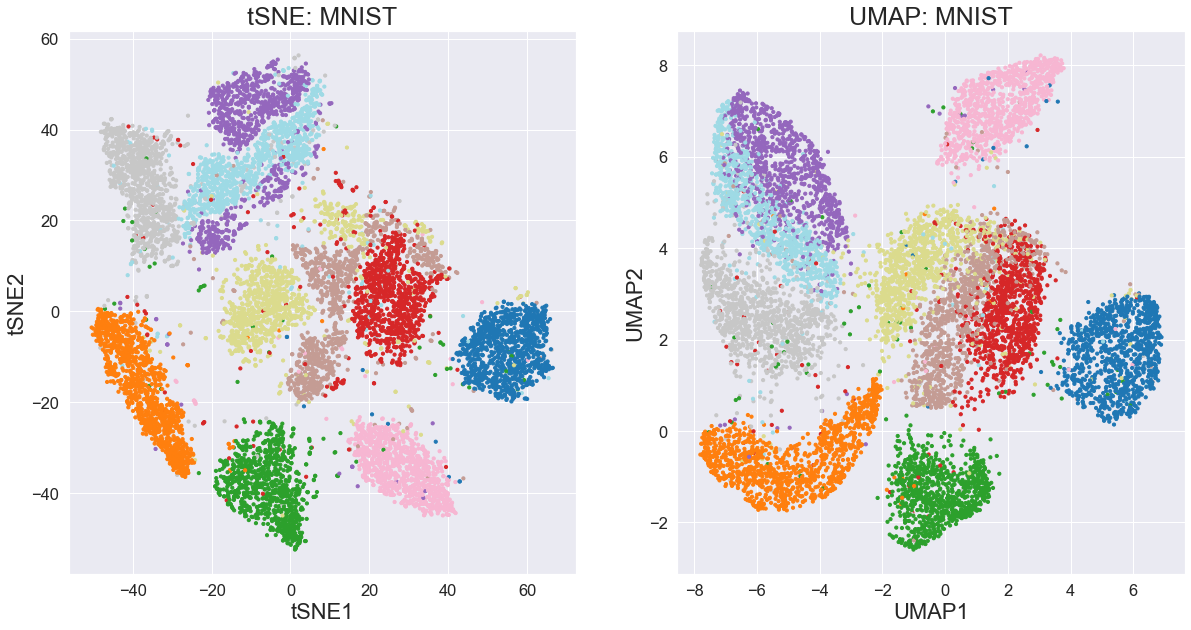

In [22]:
opt_perp = int(np.round(np.sqrt(X.shape[0]), 0))
X_reduced = PCA(n_components = N_opt_pcs).fit_transform(X)

umap_embedding = umap.UMAP(n_components = 2, n_neighbors = opt_perp,
                           init = X_reduced[:, 0:2], min_dist = 0.3, 
                           n_epochs = 1000, random_state = 123, 
                           verbose = 0).fit_transform(X_reduced)

tsne_embedding = TSNE(n_components=2, perplexity=opt_perp,
                      init = X_reduced[:, 0:2], 
                      learning_rate = 200, n_iter = 1000, 
                      random_state = 123, verbose = 0).fit_transform(X_reduced)

sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 10))

plt.subplot(121)
plt.scatter(tsne_embedding[:, 0], tsne_embedding[:, 1], 
            c = labels, s = 10, cmap = "tab20")
plt.title("tSNE: MNIST", fontsize = 25)
plt.xlabel("tSNE1", fontsize = 22)
plt.ylabel("tSNE2", fontsize = 22)

plt.subplot(122)
plt.scatter(umap_embedding[:, 0], umap_embedding[:, 1], 
            c = labels, s = 10, cmap = "tab20")
plt.title("UMAP: MNIST", fontsize = 25)
plt.xlabel("UMAP1", fontsize = 22) 
plt.ylabel("UMAP2", fontsize = 22)
plt.show()

# Variation explained by components

## PCA

In [23]:
pca = PCA(n_components = X.shape[1]).fit(X)
pca_comps = PCA().fit_transform(X)
print(pca.explained_variance_ratio_[0])

0.11043073983593528


### Computation with Partial Least Squares procedure (still in process)

In [24]:
PCA_matrix = pd.DataFrame(pca_comps[:, 0:1])
pls = PLSRegression(n_components = 1)
pls.fit(PCA_matrix, X)
y_pred = pls.predict(PCA_matrix)
print(r2_score(X, y_pred, multioutput = "variance_weighted"))

0.11043073983593503


In [25]:
print(1 - np.sum((np.array(X) - np.array(y_pred)) ** 2) / np.sum((X - np.mean(X, axis = 0)) ** 2))

pixel1              -inf
pixel2              -inf
pixel3              -inf
pixel4              -inf
pixel5              -inf
                ...     
pixel780   -1.029439e+06
pixel781            -inf
pixel782            -inf
pixel783            -inf
pixel784            -inf
Length: 784, dtype: float64


In [26]:
1 - np.sum((np.array(X) - np.array(y_pred)) ** 2) / (np.sum(np.array(X) ** 2))

0.524606514073097

In [27]:
print(1 - np.sum((np.array(X) - np.array(y_pred))**2) / np.sum((X - \
np.mean(X, axis = 0))**2))

pixel1              -inf
pixel2              -inf
pixel3              -inf
pixel4              -inf
pixel5              -inf
                ...     
pixel780   -1.029439e+06
pixel781            -inf
pixel782            -inf
pixel783            -inf
pixel784            -inf
Length: 784, dtype: float64


#### Verification of PLS correctness

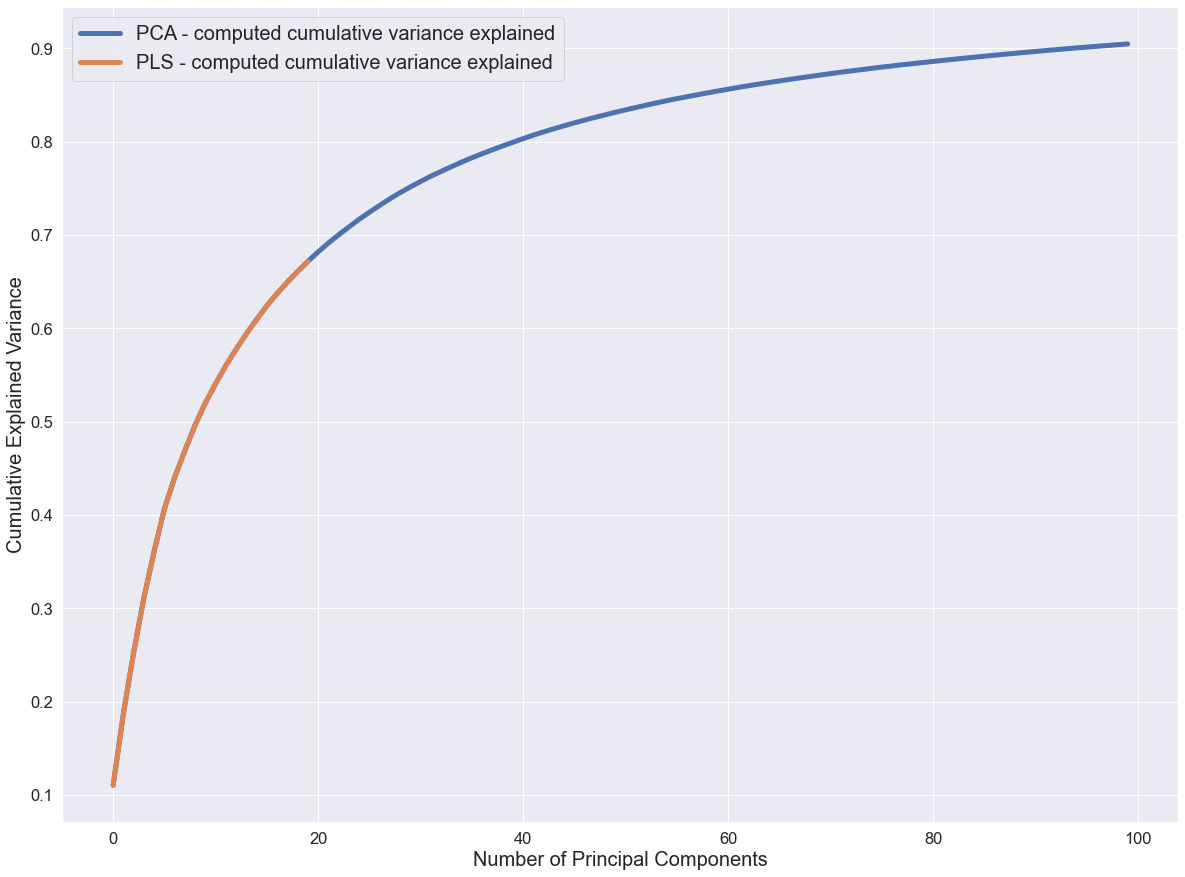

In [28]:
predicted_var_expl = []

for i in range(1, 21):
    PCA_matrix_current = pd.DataFrame(pca_comps[:, 0 : i])
    pls_current = PLSRegression(n_components = i)
    pls_current.fit(PCA_matrix_current, X)
    y_pred_current = pls_current.predict(PCA_matrix_current)
    predicted_var_expl.append(r2_score(X, y_pred_current,
                              multioutput = "variance_weighted"))
    
sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 15))
plt.plot(np.cumsum(pca.explained_variance_ratio_[0 : 100]), linewidth=5)
plt.plot(predicted_var_expl, linewidth = 5)
plt.ylabel("Cumulative Explained Variance", fontsize = 20)
plt.xlabel("Number of Principal Components", fontsize = 20)
plt.legend(["PCA - computed cumulative variance explained",
            "PLS - computed cumulative variance explained"],
            fontsize = 20)
plt.show()

## UMAP

In [29]:
UMAP_matrix = pd.DataFrame(umap_embedding[:, 0:1])
pls = PLSRegression(n_components = 1)
pls.fit(UMAP_matrix, X)
y_pred = pls.predict(UMAP_matrix)
print(r2_score(X, y_pred, multioutput = "variance_weighted"))

0.0704900854439612


In [30]:
print(1 - np.sum((np.array(X) - np.array(y_pred))**2) / np.sum((X - \
np.mean(X, axis = 0)) ** 2))

pixel1              -inf
pixel2              -inf
pixel3              -inf
pixel4              -inf
pixel5              -inf
                ...     
pixel780   -1.075659e+06
pixel781            -inf
pixel782            -inf
pixel783            -inf
pixel784            -inf
Length: 784, dtype: float64


## tSNE

In [31]:
tSNE_matrix = pd.DataFrame(tsne_embedding[:, 0:1])
pls = PLSRegression(n_components = 1)
pls.fit(tSNE_matrix, X)
y_pred = pls.predict(tSNE_matrix)
print(r2_score(X, y_pred, multioutput = "variance_weighted"))

0.07019335638065057


In [32]:
print(1 - np.sum((np.array(X) - np.array(y_pred)) ** 2) / np.sum((X - \
      np.mean(X, axis = 0)) ** 2))

pixel1              -inf
pixel2              -inf
pixel3              -inf
pixel4              -inf
pixel5              -inf
                ...     
pixel780   -1.076003e+06
pixel781            -inf
pixel782            -inf
pixel783            -inf
pixel784            -inf
Length: 784, dtype: float64


## Explained Variance by Components

In [36]:
N_iter = 3 
N_comps = 3

N_points_list = [5000, 10000, 15000]
perp_list = [50, 100, 150] 
min_dist_list = [0.1, 0.2, 0.3]

predicted_var_expl_matrix = np.zeros(shape = (N_iter, N_comps))
predicted_var_expl_umap_matrix = np.zeros(shape = (N_iter, N_comps))
predicted_var_expl_tsne_matrix = np.zeros(shape = (N_iter, N_comps))

for j in range(N_iter):
    
    # MNIST variance explained by PCA components 
    
    np.random.seed(j)
    X = np.log10(mnist.data + 1) 
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], size = N_points_list[j],
                                      replace = False)
    X_sample = X.loc[random_indices, :] 
    labels_sample = labels[random_indices]
    pca_comps_sample = PCA(n_components = N_comps).fit_transform(X_sample)
    predicted_var_expl = []
    
    for i in range(1, (N_comps + 1)) :
        
        PCA_matrix_current = pd.DataFrame(pca_comps_sample[:, 0:i])
        pls_current = PLSRegression(n_components = i)
        pls_current.fit(PCA_matrix_current, X_sample)
        y_pred_current = pls_current.predict(PCA_matrix_current)
        predicted_var_expl.append(r2_score(X_sample, y_pred_current,
                                           multioutput= "variance_weighted"))
        
    predicted_var_expl_matrix[j,:] = predicted_var_expl
    
    # MNIST variance explained by UMAP components
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], size = N_points,
                                      replace = False)
    X_sample = X.loc[random_indices, :] 
    labels_sample = labels[random_indices]
    opt_perp = int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    
    umap_embedding_sample = umap.UMAP(n_components = N_comps,
                                      n_neighbors = opt_perp,
                                      init = X_reduced_sample[:, 0 : N_comps],
                                      min_dist = min_dist_list[j],
                                      n_epochs = 1000, verbose = 0).fit_transform(X_reduced_sample)
    predicted_var_expl_umap = []

    for i in range(1, (N_comps + 1)):

        UMAP_matrix_current = pd.DataFrame(umap_embedding_sample[:, 0:i])
        pls_current = PLSRegression (n_components = i)
        pls_current.fit(UMAP_matrix_current, X_sample)
        y_pred_current = pls_current.predict(UMAP_matrix_current)
        predicted_var_expl_umap.append(r2_score(X_sample, y_pred_current, multioutput = "variance_weighted"))

    predicted_var_expl_umap_matrix[j,:] = predicted_var_expl_umap
    
    # MNIST variance explained by tSNE components
    
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
    X_sample = X.loc[random_indices, :]
    labels_sample = labels[random_indices]
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    tsne_embedding_sample = TSNE(n_components = N_comps,
                                 perplexity = perp_list[j],
                                 init = X_reduced_sample[:, 0 : N_comps],
                                 learning_rate = 200, n_iter = 1000,
                                 verbose = 0).fit_transform(X_reduced_sample)
    predicted_var_expl_tsne = []
    
    for i in range(1, (N_comps + 1)) :

        tSNE_matrix_current = pd.DataFrame(tsne_embedding_sample[:, 0:i])
        pls_current = PLSRegression(n_components = i)
        pls_current.fit(tSNE_matrix_current, X_sample)
        y_pred_current = pls_current.predict(tSNE_matrix_current)
        predicted_var_expl_tsne.append(r2_score(X_sample, y_pred_current, multioutput = "variance_weighted"))

    predicted_var_expl_tsne_matrix[j, :] = predicted_var_expl_tsne

print("MNIST variance explained by PCA components:")
print(predicted_var_expl_matrix, end = "\n")
print("MNIST variance explained by UMAP components:")
print(predicted_var_expl_umap_matrix, end = "\n")
print("MNIST variance explained by ISNE components:")
print(predicted_var_expl_tsne_matrix, end = "\n")

MNIST variance explained by PCA components:
[[0.10780598 0.18642903 0.25086806]
 [0.10939031 0.18671329 0.25279746]
 [0.10868969 0.18615405 0.25226694]]
MNIST variance explained by UMAP components:
[[0.06940963 0.11476833 0.15935462]
 [0.06863098 0.11619195 0.16014241]
 [0.07422389 0.11535796 0.16569914]]
MNIST variance explained by ISNE components:
[[0.07135875 0.1254694  0.16801202]
 [0.07131494 0.12912094 0.1744879 ]
 [0.07288095 0.12927022 0.17326812]]


## Plot of Components Variance Explained

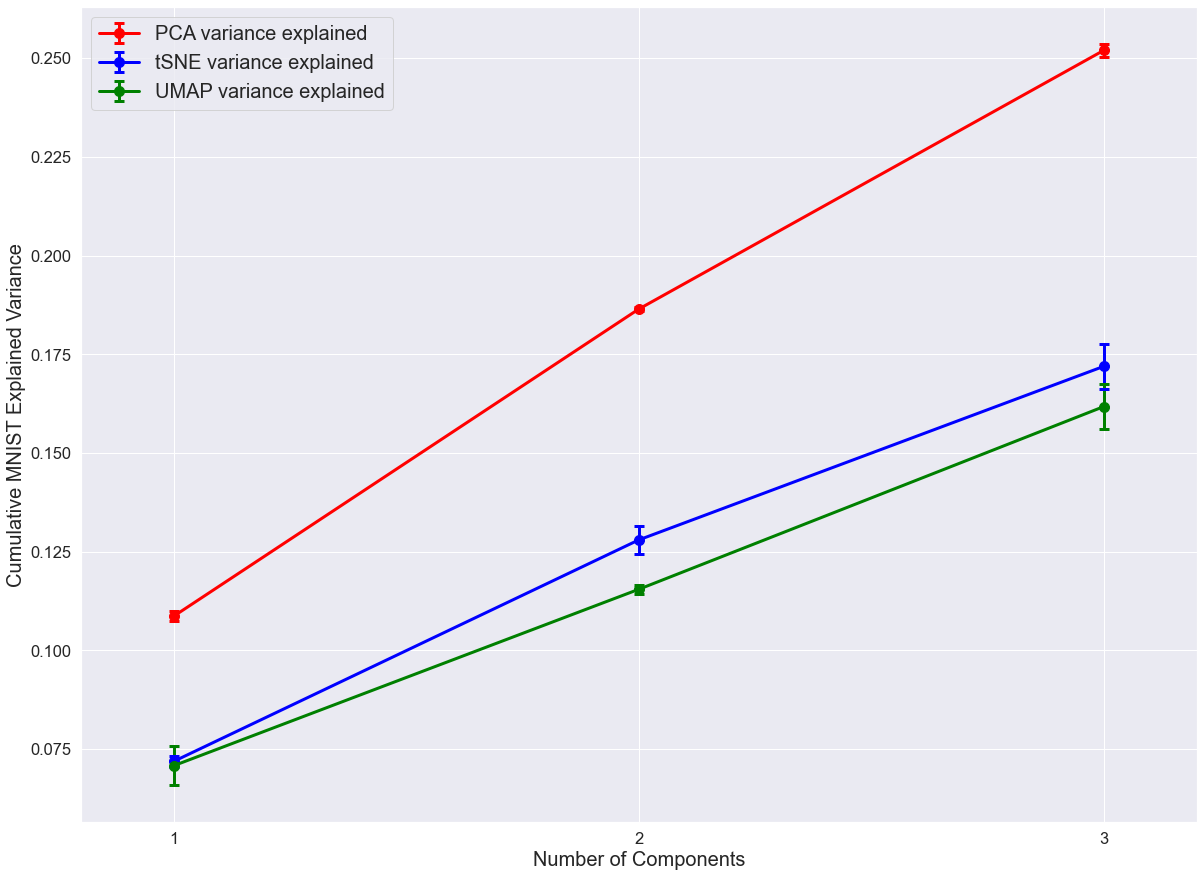

In [37]:
# Plot MNIST variance explained by leading PCA, tSNE and UMAP components

sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 15))

plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_matrix, axis = 0), 
             yerr = 2 * np.std (predicted_var_expl_matrix, axis = 0), linewidth = 3, 
             color = "red", marker = "o", markersize = 10, capsize = 5, capthick = 3)

plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_tsne_matrix, axis = 0), 
             yerr = 2 * np.std(predicted_var_expl_tsne_matrix, axis = 0), linewidth = 3, 
             color = "blue", marker = "o", markersize = 10, capsize = 5, capthick = 3)

plt.errorbar(range(1, (N_comps + 1)), np.mean(predicted_var_expl_umap_matrix, axis = 0), 
             yerr = 2 * np.std(predicted_var_expl_umap_matrix, axis = 0), linewidth = 3, 
             color = "green", marker = "o", markersize = 10, capsize = 5, capthick = 3)

plt.ylabel("Cumulative MNIST Explained Variance", fontsize = 20)
plt.xlabel("Number of Components", fontsize = 20)
plt.legend(["PCA variance explained", 
            "tSNE variance explained", 
            "UMAP variance explained"], fontsize = 20)
plt.xlim([0.8, (N_comps + 0.2)]) 
plt.xticks([1, 2, 3])
plt.show()

## Biological Variantion

/Users/RomanGorelsky/opt/anaconda3/lib/python3.8/site-packages/umap/umap_.py:1943: UserWarning: n_jobs value -1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(f"n_jobs value {self.n_jobs} overridden to 1 by setting random_state. Use no seed for parallelism.")


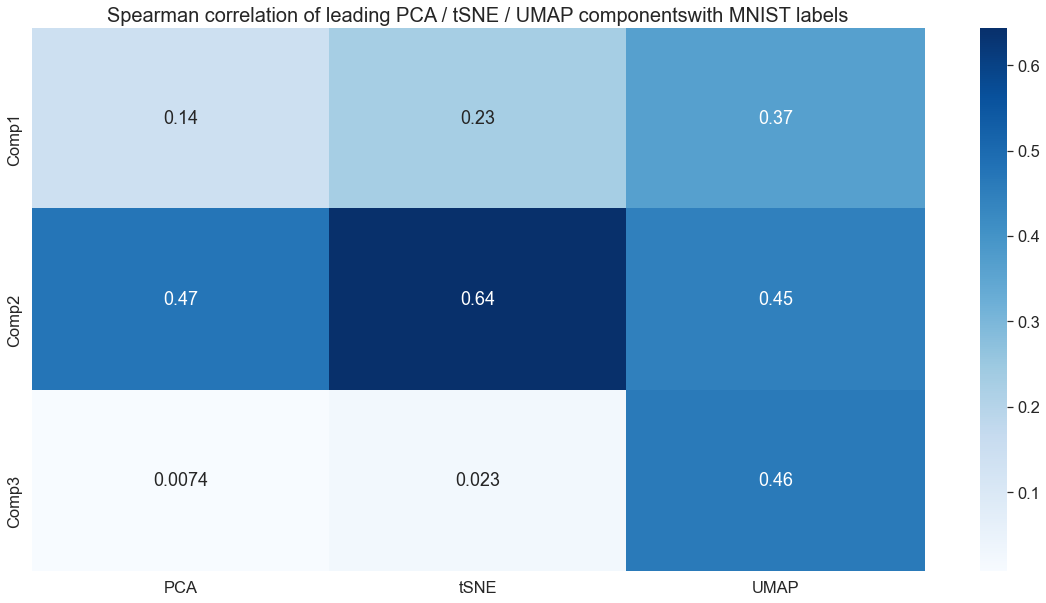

In [41]:
N_comps = 3
N_points = 10000
mnist = fetch_openml("mnist_784", version = 1)
labels = mnist.target.astype(int) 
X = np.log10(mnist.data + 1)

# Subsample MNIST data down to 10 000 images np.random.seed (123)

random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
X = X.loc[random_indices, :]
labels = labels[random_indices]

# Compute top 3 PCA components on the subsampled MNIST data

pca = PCA(n_components = N_comps).fit(X)
pca_comps = PCA().fit_transform(X)

# Compute top 3 UMAP components on the subsampled MNIST data

opt_perp = int(np.round(np.sqrt(X.shape[0]), 0))
X_reduced = PCA(n_components = N_opt_pcs).fit_transform(X)
umap_embedding = umap.UMAP(n_components = N_comps, n_neighbors = opt_perp,
                           init = X_reduced[:, 0 : N_comps],
                           min_dist = 0.3, n_epochs = 1000, random_state=123,
                           verbose = 0).fit_transform(X_reduced)

#Compute top 3 tSNE components on the subsampled MNIST data

tsne_embedding = TSNE(n_components = N_comps, perplexity = opt_perp,
                      init = X_reduced[:, 0 : N_comps], learning_rate = 200, 
                      n_iter = 1000, random_state = 123, verbose = 0).fit_transform(X_reduced)

#Pairwise correlations between MNIST labels and PCA / SNE / UMAP components

rho_matrix = np.zeros(shape = (3, 3))

for i in range(N_comps):
    
    rho, pval = spearmanr(pca_comps[:, i], labels)
    rho_matrix[0, i] = abs(rho)

for i in range(N_comps):
    
    rho, pval = spearmanr(tsne_embedding[:, i], labels)
    rho_matrix[1, i] = abs(rho)

for i in range(N_comps):
    
    rho, pval = spearmanr(umap_embedding[:, i], labels)
    rho_matrix[2, i] = abs(rho)

rho_df = pd.DataFrame(rho_matrix, columns = ["Comp1", "Comp2", "Comp3"],
                      index = ["PCA", "tSNE", "UMAP"])
sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 10))
sns.heatmap(rho_df.T, cmap = "Blues", annot = True)
plt.title("Spearman correlation of leading PCA / tSNE / UMAP components" +
          "with MNIST labels", fontsize = 20)
plt.show()

In [44]:
# Variance in MNIST labels explained by PC1

pca = PCA(n_components = X.shape[1]).fit(X)
pca_comps = PCA().fit_transform(X)
PCA_matrix = pd.DataFrame(pca_comps[:, 0 : 1])
pls = PLSRegression(n_components = 1)
pls.fit(PCA_matrix, labels)
y_pred = pls.predict(PCA_matrix)
print("PC1: ", r2_score(labels, y_pred, multioutput = "variance_weighted"), end = "\n")

# Variance in MNIST labels explained by tSNE1

tSNE_matrix = pd.DataFrame(tsne_embedding[:, 0 : 1])
pls = PLSRegression(n_components = 1)
pls.fit(tSNE_matrix, labels)
y_pred = pls.predict(tSNE_matrix)
print("tSNE1: ", r2_score(labels, y_pred, multioutput = "variance_weighted"), end = "\n")

# Variance in MNIST labels explained by UMAP1

UMAP_matrix = pd.DataFrame(umap_embedding[:, 0 : 1])
pls = PLSRegression(n_components = 1)
pls.fit(UMAP_matrix, labels)
y_pred = pls.predict(UMAP_matrix)
print("UMAP1: ", r2_score (labels, y_pred, multioutput = "variance_weighted"), end = "\n")

PC1:  0.0298503911592719
tSNE1:  0.0460775519645622
UMAP1:  0.15819123881897534


In [48]:
my_df_comps = pd.DataFrame({"LABELS": labels,
                           "PC1": np.array(PCA_matrix).flatten(),
                           "tSNE1": np.array(tSNE_matrix).flatten(),
                           "UMAP1": np.array(UMAP_matrix).flatten()})

In [49]:
smf.ols(formula = "LABELS ~ PC1", data = my_df_comps).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LABELS   R-squared:                       0.030
Model:                            OLS   Adj. R-squared:                  0.030
Method:                 Least Squares   F-statistic:                     307.6
Date:                Fri, 09 Aug 2024   Prob (F-statistic):           7.41e-68
Time:                        19:17:59   Log-Likelihood:                -24565.
No. Observations:               10000   AIC:                         4.913e+04
Df Residuals:                    9998   BIC:                         4.915e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4796      0.028    158.697      0.000       4.424       4.535
PC1           -0.0780      0.004    -17.539      0.000      -0.087      -0.069
==============================================================================
Omnibus:                    13286.507   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              641.713
Skew:                          -0.011   Prob(JB):                    4.51e-140
Kurtosis:                       1.759   Cond. No.                         6.35
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [50]:
smf.ols(formula = "LABELS ~ tSNE1", data = my_df_comps).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LABELS   R-squared:                       0.046
Model:                            OLS   Adj. R-squared:                  0.046
Method:                 Least Squares   F-statistic:                     482.9
Date:                Fri, 09 Aug 2024   Prob (F-statistic):          1.43e-104
Time:                        19:18:20   Log-Likelihood:                -24481.
No. Observations:               10000   AIC:                         4.897e+04
Df Residuals:                    9998   BIC:                         4.898e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.4544      0.028    159.006      0.000       4.399       4.509
tSNE1         -0.0665      0.003    -21.976      0.000      -0.072      -0.061
==============================================================================
Omnibus:                     9255.587   Durbin-Watson:                   1.994
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              616.500
Skew:                          -0.077   Prob(JB):                    1.34e-134
Kurtosis:                       1.793   Cond. No.                         9.26
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [51]:
smf.ols(formula = "LABELS ~ UMAP1", data = my_df_comps).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 LABELS   R-squared:                       0.158
Model:                            OLS   Adj. R-squared:                  0.158
Method:                 Least Squares   F-statistic:                     1879.
Date:                Fri, 09 Aug 2024   Prob (F-statistic):               0.00
Time:                        19:18:33   Log-Likelihood:                -23856.
No. Observations:               10000   AIC:                         4.772e+04
Df Residuals:                    9998   BIC:                         4.773e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.0134      0.028    141.274      0.000       3.958       4.069
UMAP1         -0.4851      0.011    -43.345      0.000      -0.507      -0.463
==============================================================================
Omnibus:                     3034.757   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              481.622
Skew:                          -0.116   Prob(JB):                    2.61e-105
Kurtosis:                       1.950   Cond. No.                         2.81
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Cumulative Variance Explained Change

In [54]:
N_iter = 3
N_comps = 3

N_points_list = [5000, 10000, 15000]
min_dist_list = [0.1, 0.2, 0.3]
perp_list = [90, 100, 110]
predicted_var_expl_labels_matrix = np.zeros(shape = (N_iter, N_comps))
predicted_var_expl_labels_umap_matrix=np.zeros(shape=(N_iter, N_comps))
predicted_var_expl_labels_tsne_matrix=np.zeros(shape=(N_iter, N_comps))
                 
for j in range(N_iter):
                 
    # Variance in MNIST labels explained by PCA components 
    np.random.seed(j)
                 
    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], 
                                      size = N_points_list[j],
                                      replace = False)
    X_sample = X.loc[random_indices, :]
    labels_sample = labels[random_indices]
    pca_comps_sample = PCA(n_components = N_comps).fit_transform(X_sample)

    predicted_var_expl_labels = []
    
    for i in range(1, (N_comps + 1)) :

        PCA_matrix_current_labels = pd.DataFrame(pca_comps_sample[:, 0 : i])
        pls_current_labels = PLSRegression(n_components = i)
        pls_current_labels.fit(PCA_matrix_current_labels, labels_sample)
        y_pred_current_labels = pls_current_labels.predict(PCA_matrix_current_labels)
        predicted_var_expl_labels.append(r2_score(labels_sample, 
                                                  y_pred_current_labels, 
                                                  multioutput = "variance_weighted"))

    predicted_var_expl_labels_matrix[j,:] = predicted_var_expl_labels

    # Variance in MNIST labels explained by UMAP components

    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], 
                                      size = N_points, 
                                      replace = False)
    X_sample = X.loc[random_indices, :]
    labels_sample = labels[random_indices]
    opt_perp = int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    umap_embedding_sample = umap.UMAP(n_components = N_comps,
                                      n_neighbors = opt_perp,
                                      init = X_reduced_sample[:, 0 : N_comps],
                                      min_dist = min_dist_list[j],
                                      n_epochs = 1000, verbose = 0).fit_transform(X_reduced_sample)
    predicted_var_expl_labels_umap = []

    for i in range(1, (N_comps + 1)):

        UMAP_matrix_current_labels = pd.DataFrame(umap_embedding_sample[:, 0 : i])
        pls_current_labels_umap = PLSRegression(n_components = i)
        pls_current_labels_umap.fit(UMAP_matrix_current_labels, labels_sample)
        y_pred_current_labels_umap = pls_current_labels_umap.predict(UMAP_matrix_current_labels)
        predicted_var_expl_labels_umap.append(r2_score(labels_sample,
                                                       y_pred_current_labels_umap, 
                                                       multioutput = "variance_weighted"))
    
    predicted_var_expl_labels_umap_matrix[j, :] = predicted_var_expl_labels_umap
    
    # Variance in MNIST labels explained by tSNE components

    X = np.log10(mnist.data + 1)
    labels = mnist.target.astype(int)
    random_indices = np.random.choice(X.shape[0], size = N_points, replace = False)
    X_sample = X.loc[random_indices, :]
    labels_sample = labels[random_indices]
    opt_perp = int(np.round(np.sqrt(X_sample.shape[0]), 0))
    X_reduced_sample = PCA(n_components = N_opt_pcs).fit_transform(X_sample)
    tsne_embedding_sample = TSNE(n_components = N_comps,
                                 perplexity = perp_list[j],
                                 init = X_reduced_sample[:, 0 : N_comps],
                                 learning_rate = 200, n_iter = 1000,
                                 verbose = 0).fit_transform(X_reduced_sample)
    predicted_var_expl_labels_tsne = []

    for i in range(1, (N_comps + 1)):

        tSNE_matrix_current_labels = pd.DataFrame(tsne_embedding_sample[:, 0 : i])
        pls_current_labels_tsne = PLSRegression(n_components = i)
        pls_current_labels_tsne.fit(tSNE_matrix_current_labels, labels_sample)
        y_pred_current_labels_tsne = pls_current_labels_tsne.predict(tSNE_matrix_current_labels)
        predicted_var_expl_labels_tsne.append(r2_score(labels_sample, 
                                                       y_pred_current_labels_tsne, 
                                                       multioutput = 'variance_weighted'))
                                                
    predicted_var_expl_labels_tsne_matrix[j, :]=predicted_var_expl_labels_tsne

In [56]:
print("Variance in MNIST labels explained by PCA components: ")
print(predicted_var_expl_labels_matrix, end = "\n")
print("Variance in MNIST labels explained by UMAP components: ")
print(predicted_var_expl_labels_umap_matrix, end = "\n")
print("Variance in MNIST labels explained by tSNE components: ")
print(predicted_var_expl_labels_tsne_matrix, end = "\n")

Variance in MNIST labels explained by PCA components: 
[[0.03418984 0.27663261 0.29223446]
 [0.0265549  0.28409257 0.28739842]
 [0.03096174 0.27898829 0.2794116 ]]
Variance in MNIST labels explained by UMAP components: 
[[0.1289694  0.40514176 0.44924968]
 [0.08865035 0.49597584 0.49875978]
 [0.14763686 0.3854718  0.41961617]]
Variance in MNIST labels explained by tSNE components: 
[[0.05340277 0.36552371 0.36743963]
 [0.04746316 0.41906127 0.42597181]
 [0.06034163 0.3407808  0.37130134]]


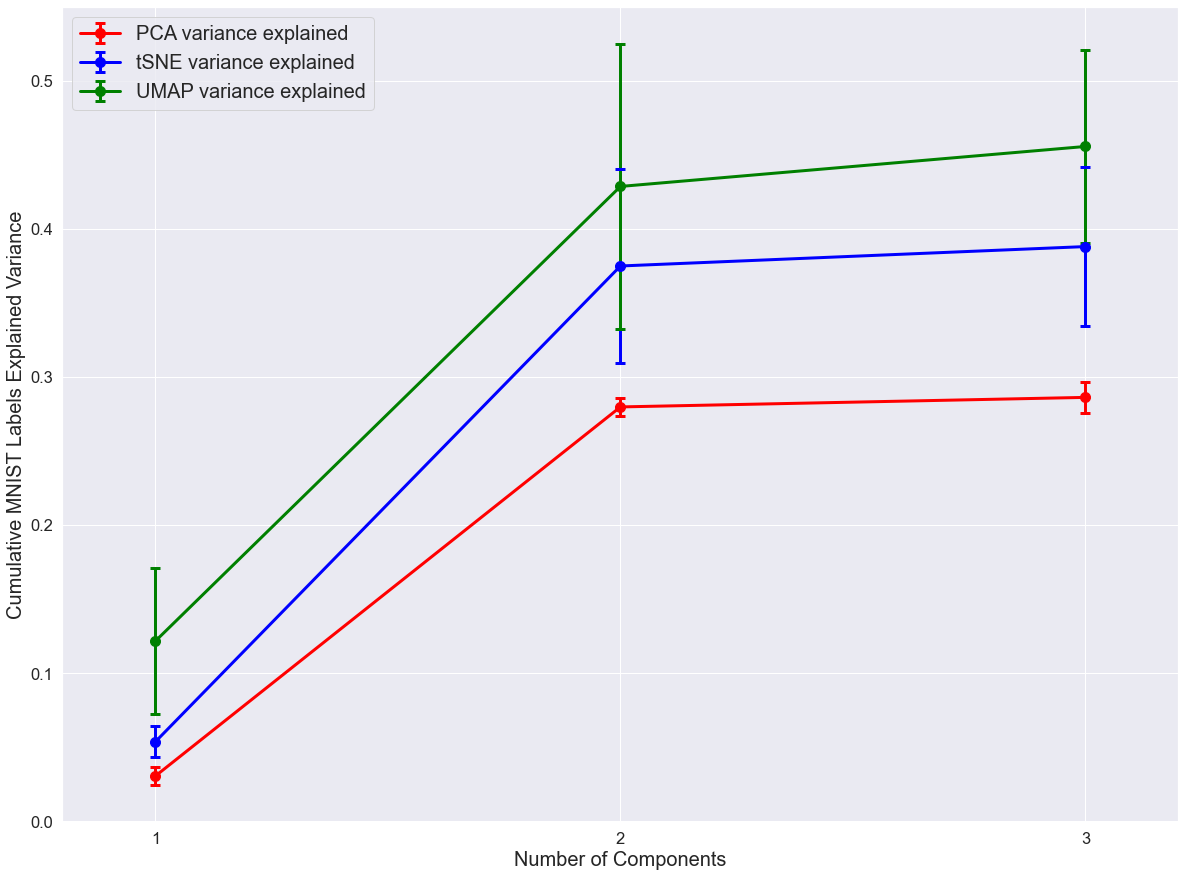

In [57]:
# Plot MNIST labels variance explained by PCA, tSNE and UMAP components

sns.set(font_scale = 1.5)
plt.figure(figsize = (20, 15))
plt.errorbar(range(1, (N_comps + 1)),
             np.mean(predicted_var_expl_labels_matrix, axis = 0),
             yerr = 2 * np.std(predicted_var_expl_labels_matrix, axis = 0),
             linewidth = 3, color = "red", marker = "o", markersize = 10, capsize = 5, capthick = 3)

plt.errorbar(range(1, (N_comps + 1)),
             np.mean(predicted_var_expl_labels_tsne_matrix, axis = 0),
             yerr = 2 * np.std(predicted_var_expl_labels_tsne_matrix, axis = 0),
             linewidth = 3, color = "blue", marker = "o", markersize = 10, capsize = 5, capthick = 3)

plt.errorbar(range (1, (N_comps + 1)),
             np.mean(predicted_var_expl_labels_umap_matrix, axis = 0),
             yerr = 2 * np.std(predicted_var_expl_labels_umap_matrix, axis = 0),
             linewidth = 3, color = "green", marker = "o", markersize = 10, capsize = 5, capthick = 3)

plt.ylabel ("Cumulative MNIST Labels Explained Variance", fontsize = 20)
plt.xlabel("Number of Components", fontsize = 20)
plt.legend(["PCA variance explained", 
            "tSNE variance explained",
            "UMAP variance explained"], fontsize = 20)
plt.xlim([0.8, (N_comps + 0.2)]) 
plt.xticks([1, 2, 3])
plt.show()